In [1]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path

print(Path().cwd())
os.chdir(Path(os.getcwd()).parent)
print(Path().cwd())

/Users/samantha/QuantUS-Plugins-CEUS/2d ceus test
/Users/samantha/QuantUS-Plugins-CEUS


## Select Contrast-Enhanced Ultrasound (CEUS) Cine and Parser

In [2]:
from src.image_loading.options import get_scan_loaders

print("Available scan loaders:", list(get_scan_loaders().keys()))

Available scan loaders: ['avi', 'nifti', 'custom_dicom', 'mp4']


In [3]:
scan_type = 'mp4'

scan_path = '/Users/samantha/Desktop/ultrasound lab stuff/ctdna/p14/p14 wk6/p14_wk6.mp4'
scan_loader_kwargs = {
    'transpose': False,
}

In [4]:
from src.entrypoints import scan_loading_step

image_data = scan_loading_step(scan_type, scan_path, **scan_loader_kwargs)

## Image Preprocessing

In [5]:
from src.image_preprocessing.options import get_im_preproc_funcs, get_required_im_preproc_kwargs

print("Available preprocessing functions:", list(get_im_preproc_funcs().keys()))

Available preprocessing functions: ['standardize', 'resample']


In [6]:
preproc_func_names = [] # in order of application
required_kwargs = get_required_im_preproc_kwargs(preproc_func_names)
print("Required kwargs for preprocessing functions:", required_kwargs)

Required kwargs for preprocessing functions: []


In [7]:
preproc_kwargs = {
    'target_vox_size': (1.0, 1.0, 1,.0),
    'interp': 'linear',
}

In [8]:
from src.entrypoints import scan_preprocessing_step

image_data = scan_preprocessing_step(preproc_func_names, image_data, **preproc_kwargs)

## Load Segmentation

Assumes same segmentation for each frame

In [9]:
from src.seg_loading.options import get_seg_loaders

print("Available segmentation loaders:", list(get_seg_loaders().keys()))

Available segmentation loaders: ['nifti', 'load_bolus_mask']


In [10]:
seg_type = 'nifti'

seg_path = '/Users/samantha/Desktop/ultrasound lab stuff/ctdna/p14/p14 wk6/p14_wk6_roi.nii.gz'
seg_loader_kwargs = {}

In [11]:
from src.entrypoints import seg_loading_step

seg_data = seg_loading_step(seg_type, image_data, seg_path, scan_path, **seg_loader_kwargs)

## Segmentation Preprocessing

In [12]:
from src.seg_preprocessing.options import get_seg_preproc_funcs, get_required_seg_preproc_kwargs

print("Available preprocessing functions:", list(get_seg_preproc_funcs().keys()))

Available preprocessing functions: ['resample']


In [13]:
preproc_func_names = [] # in order of application
required_kwargs = get_required_seg_preproc_kwargs(preproc_func_names)
print("Required kwargs for preprocessing functions:", required_kwargs)

Required kwargs for preprocessing functions: []


In [14]:
preproc_kwargs = {
    'target_vox_size': (1.0, 1.0, 1.0),
    'interp': 'nearest',
}

In [15]:
from src.entrypoints import seg_preprocessing_step

seg_data = seg_preprocessing_step(preproc_func_names, image_data, seg_data, **preproc_kwargs)

## CEUS Quantitative Temporal Curve Analysis

In [16]:
from src.time_series_analysis.options import get_analysis_types, get_required_kwargs

all_analysis_types, all_analysis_funcs = get_analysis_types()
print("Available analysis types:", list(all_analysis_types.keys()))

Available analysis types: ['curves_paramap', 'curves']


In [17]:
analysis_type = 'curves'

print("Available analysis functions:", list(all_analysis_funcs.keys()))

Available analysis functions: ['pyradiomics', 'tic']


In [18]:
analysis_funcs = ['tic']

# Find all required kwargs for the analysis functions
analysis_funcs = analysis_funcs if len(analysis_funcs) else list(all_analysis_funcs[analysis_type].keys())
required_kwargs = get_required_kwargs(analysis_type, analysis_funcs)
print("Required kwargs for current analysis:", required_kwargs)

Required kwargs for current analysis: []


In [19]:
analysis_kwargs = {
#    # 'pyradiomics_config_paths': [
#    #     '/home/das/QuantUS_Projs/QuantUS-Plugins-CEUS/configs/pyradiomics/moderate-pselectin.yml',
#    # ],
#    # 'curves_output_path': 'test2.csv',
#    # 'binwidth': 25,
#    # 'min_intensity': 0,
 }

In [20]:
from src.entrypoints import analysis_step

analysis_obj = analysis_step(analysis_type, image_data, seg_data, analysis_funcs, **analysis_kwargs)

Computing curves: 100%|██████████| 826/826 [00:02<00:00, 364.72it/s]


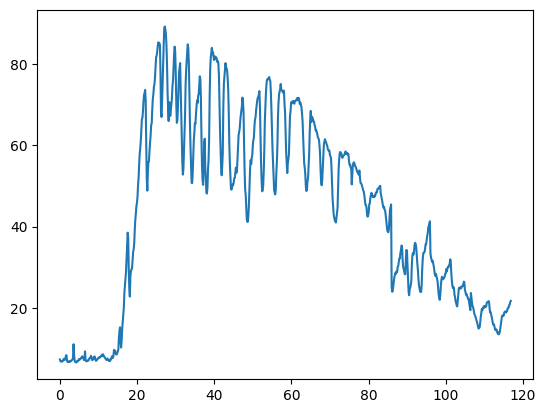

In [21]:
import matplotlib.pyplot as plt

t = analysis_obj.time_arr
tic = analysis_obj.curves[0]['TIC']
plt.plot(t, tic)

## Curve Quantification

In [22]:
from src.curve_quantification.options import get_quantification_funcs

quantification_funcs = get_quantification_funcs()
print("Available quantification functions:", quantification_funcs.keys())

Available quantification functions: dict_keys(['auc_no_fit', 'cmus_firstorder', 'dte', 'first_order_full', 'first_order_select', 'lognormal_fit_full', 'lognormal_fit_select', 'wash_rates'])


In [23]:
function_names = [] # Empty list will use all functions
output_path = '/Users/samantha/Desktop/ultrasound lab stuff/ctdna/curve_quant_raw.csv'
curve_quantifications_kwargs = {
    'curves_to_fit': ['TIC'],
    'n_frames_to_analyze': 100,
    'tic_name': 'TIC'
}

In [24]:
from src.entrypoints import curve_quantification_step

curve_quant = curve_quantification_step(analysis_obj, function_names, output_path, **curve_quantifications_kwargs)

['auc_no_fit', 'cmus_firstorder', 'dte', 'first_order_full', 'first_order_select', 'lognormal_fit_full', 'lognormal_fit_select', 'wash_rates']
Ordered functions: ['auc_no_fit', 'lognormal_fit_full', 'lognormal_fit_select', 'cmus_firstorder', 'dte', 'first_order_full', 'first_order_select', 'wash_rates']
IN COMPUTER_QUANTIFICATIONS FUNCTIONS
['auc_no_fit', 'lognormal_fit_full', 'lognormal_fit_select', 'cmus_firstorder', 'dte', 'first_order_full', 'first_order_select', 'wash_rates']


In [25]:
print(curve_quant.data_dict)
print(len(curve_quant.data_dict))
type(curve_quant.data_dict[0])

[{'Scan Name': 'p14_wk6', 'Segmentation Name': 'p14_wk6_roi', 'AUC_NoFit_TIC': np.float64(57.06355565586055), 'AUC_full_TIC': np.float64(70.73152531499065), 'PE_full_TIC': np.float64(0.8344533176163055), 'TP_full_TIC': np.float64(22.170600191428317), 'MTT_full_TIC': np.float64(88.61551965166213), 'T0_full_TIC': np.float64(11.897983924575524), 'Mu_full_TIC': np.float64(4.022460370258613), 'Sigma_full_TIC': np.float64(0.9610896288915071), 'PE_Ix_full_TIC': np.int64(240), 'AUC_select_TIC': np.float64(70.73152531499065), 'PE_select_TIC': np.float64(0.8344533176163055), 'TP_select_TIC': np.float64(22.170600191428317), 'MTT_select_TIC': np.float64(88.61551965166213), 'T0_select_TIC': np.float64(11.897983924575524), 'Mu_select_TIC': np.float64(4.022460370258613), 'Sigma_select_TIC': np.float64(0.9610896288915071), 'PE_Ix_select_TIC': np.int64(240), 'WashIn_Mean_TIC': np.float64(28.363529738608058), 'WashIn_Std_TIC': np.float64(27.929517426913677), 'WashIn_Max_TIC': np.float64(89.1750978461638

dict

In [26]:
# output csv path
out_path = "/Users/samantha/Desktop/ultrasound lab stuff/ctdna/output.csv"

In [27]:
import pandas as pd
import os
from datetime import datetime

# convert dict to DataFrame row
data = curve_quant.data_dict[0]
df = pd.DataFrame([data])

scan_col = "Scan Name"  # column to check for duplicates
timestamp_col = "Timestamp"  # name of the new column
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
df[timestamp_col] = timestamp

if os.path.exists(out_path):
    # Load existing file
    existing = pd.read_csv(out_path)
    
    # If timestamp column doesn’t exist in the old file, add it
    if timestamp_col not in existing.columns:
        existing[timestamp_col] = pd.NaT
        existing.to_csv(out_path, index=False)
        print(f"Added missing '{timestamp_col}' column to {out_path}.")

    # Check schema (ignore column order differences)
    assert set(existing.columns) == set(df.columns), \
        f"Column mismatch! Existing: {existing.columns.tolist()} New: {df.columns.tolist()}"

    # Append regardless of duplicates
    df.to_csv(out_path, mode="a", header=False, index=False)
    print(f"Appended scan '{data[scan_col]}' to {out_path} at {timestamp}.")

else:
    # First time: write new file with header
    df.to_csv(out_path, index=False)
    print(f"Created {out_path} with scan '{data[scan_col]}' at {timestamp}.")

Appended scan 'p14_wk6' to /Users/samantha/Desktop/ultrasound lab stuff/ctdna/output.csv at 2025-10-06 17:13:52.


In [28]:
for key, value in curve_quant.data_dict[0].items():
    print(key)
    print(value)
    print()

Scan Name
p14_wk6

Segmentation Name
p14_wk6_roi

AUC_NoFit_TIC
57.06355565586055

AUC_full_TIC
70.73152531499065

PE_full_TIC
0.8344533176163055

TP_full_TIC
22.170600191428317

MTT_full_TIC
88.61551965166213

T0_full_TIC
11.897983924575524

Mu_full_TIC
4.022460370258613

Sigma_full_TIC
0.9610896288915071

PE_Ix_full_TIC
240

AUC_select_TIC
70.73152531499065

PE_select_TIC
0.8344533176163055

TP_select_TIC
22.170600191428317

MTT_select_TIC
88.61551965166213

T0_select_TIC
11.897983924575524

Mu_select_TIC
4.022460370258613

Sigma_select_TIC
0.9610896288915071

PE_Ix_select_TIC
240

WashIn_Mean_TIC
28.363529738608058

WashIn_Std_TIC
27.929517426913677

WashIn_Max_TIC
89.17509784616387

WashIn_Min_TIC
6.575603961040546

WashIn_Median_TIC
8.57048992245539

WashIn_Variance_TIC
780.0579437002747

WashIn_Skewness_TIC
0.9264177840387533

WashIn_Kurtosis_TIC
-0.7491199885173079

WashIn_Range_TIC
82.59949388512332

WashIn_InterquartileRange_TIC
45.061372531469445

WashIn_Entropy_TIC
4.8337010